# Explore syntax parsing for detection of opinion holders and targets

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [3]:
import json

In [4]:
review_data_file = '../lexicon/data/yelp_sample.json'
with open(review_data_file, 'r') as infile:
    R = json.load(infile)

In [5]:
def spacy_sentences(nlp, text):
    sentences = []
    for sent in nlp(text).sents:
        sentences.append(sent)
    return sentences

In [6]:
R[0]

{'content': "Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!",
 'date': '2014-02-17',
 'stars': 4,
 'useful': 1,
 'funny': 0,
 'cool': 0,
 'business': 'Ue6-WhXvI-_1xUIuapl0zQ',
 'id': '----X0BIDP9tA49U3RvdSQ',
 'categories': ['American (Traditional)', 'Burgers', 'Restaurants']}

In [7]:
sample = spacy_sentences(nlp, R[0]['content'])

In [8]:
sample

[Red, white and bleu salad was super yum and a great addition to the menu!,
 This location was clean with great service and food served at just the right temps!,
 Kids pizza is always a hit too with lots of great side dish options for the kiddos!,
 When I'm on this side of town, this will definitely be a spot I'll hit up again!]

In [9]:
type(sample[0])

spacy.tokens.span.Span

## Build a graph of the sentences

In [10]:
import networkx as nx
from spacy.displacy import render

In [11]:
test = sample[0]

In [12]:
render(test)

In [13]:
data = pd.DataFrame([{
    'token_id': i, 'token': x.idx, 'text': x.text, 'pos': x.pos_, 'lemma': x.lemma_,
    'dep': x.dep_, 'head': x.head.idx
} for i, x in enumerate(test)])

In [14]:
data

,token_id,token,text,pos,lemma,dep,head
0,0,0,Red,ADJ,red,amod,20
1,1,3,",",PUNCT,",",punct,0
2,2,5,white,ADJ,white,conj,0
3,3,11,and,CCONJ,and,cc,5
4,4,15,bleu,PROPN,bleu,conj,5
5,5,20,salad,NOUN,salad,nsubj,26
6,6,26,was,AUX,be,ROOT,26
7,7,30,super,ADJ,super,amod,36
8,8,36,yum,NOUN,yum,attr,26
9,9,40,and,CCONJ,and,cc,36


## Explore the graph for detecting the target of adjectives and verbs
- hints: create a statistics of the adjectives and verbs most common dependencies

In [15]:
token_map = lambda span: dict([(x.idx, x) for x in span])

In [16]:
def explore(token, children=None, level=0, order=None):
    if children is None:
        children = []
    if order is None:
        order = token.idx
    for child in token.children:
        children.append((child, level, child.idx < order))
        explore(child, children=children, level=level+1, order=order)
    return children

### Left side adjectives
Search for adjectives on the left side of the dependency tree but exclude adjectives found after another noun in the tree

In [17]:
def search_adjectives(nlp_text, nouns=None):
    nouns_map = dict([(x, []) for x in nlp_text if x.pos_ in ['NOUN', 'PROPN']])
    if nouns is None:
        nouns = nouns_map.keys()
    else:
        pass
    for noun in nouns:
        subtree = explore(noun)
        subnouns = [(x, l) for x, l, _ in subtree if x.pos_ in ['NOUN', 'PROPN']]
        for token, level, left in subtree:
            if token.pos_ == 'ADJ' and len([(n, l) for n, l in subnouns if l < level]) == 0:
                try:
                    nouns_map[noun].append(token)
                except KeyError:
                    pass
    return nouns_map

### Verb patterns
Search for the pattern
$$
NOUN \rightarrow BE\ (VERB)\ \rightarrow ADJ
$$
For the noun, we search for a subject. For the adjective:
- get only `dobj`, `attr` and `conj` **or** level 0 adjectives
- add level 0 adjectives to the adjective map for the corresponding subject noun
- for nouns, get the adjective map and add the adjectives to the subject

**Important** in this example we do not deal with negation. Address negation as an exercise.

In [18]:
def verb_adjectives(text, adjective_map):
    be_verbs = [x for x in text if x.lemma_ == 'be']
    for be in be_verbs:
        subtokens = explore(be)
        subject = [(x) for x, level, left in subtokens if left and x.dep_ == 'nsubj']
        if len(subject) > 0:
            subj = subject[0]
            for candidate, level, left in subtokens:
                if not left:
                    if candidate.pos_ == 'ADJ' and level == 0:
                        try:
                            adjective_map[subj].append(candidate)
                        except KeyError:
                            pass
                    elif candidate.dep_ in ['dobj', 'attr', 'conj']:
                        adj = search_adjectives(text, nouns=[candidate])
                        try:
                            adjective_map[subj] += adj[candidate]
                        except KeyError:
                            pass
                    else:
                        pass

### Example

In [19]:
test

Red, white and bleu salad was super yum and a great addition to the menu!

In [20]:
nm = search_adjectives(test)
nm

{bleu: [], salad: [Red, white], yum: [super], addition: [great], menu: []}

In [21]:
verb_adjectives(test, adjective_map=nm)

In [22]:
nm

{bleu: [],
 salad: [Red, white, super, great],
 yum: [super],
 addition: [great],
 menu: []}

In [23]:
s = nlp("this salad wasn't good")
nms = search_adjectives(s)
verb_adjectives(s, adjective_map=nms)
nms
render(s)

## Find meaningful pairs ADJ-NOUN per business category
We now exploit our search functions to get stats about the adjective-noun pairs and the corresponding business categories.

In [24]:
documents, stars, categories = [], [], []
for i, review in enumerate(R[:3000]):
    documents.append(review['content'])
    stars.append(review['stars'])
    categories.append(review['categories'])

In [25]:
categories[0]

['American (Traditional)', 'Burgers', 'Restaurants']

In [26]:
stats_data = []
runs = list(enumerate(documents))
for i, doc in tqdm(runs):
    cats = categories[i]
    star = stars[i]
    sample = spacy_sentences(nlp, doc)
    for sent in sample:
        nm = search_adjectives(sent)
        verb_adjectives(sent, adjective_map=nm)
        for n, adjs in nm.items():
            for a in adjs:
                for cat in cats:
                    stats_data.append({
                        'doc': i,
                        'category': cat,
                        'adj': a.lemma_.lower(),
                        'noun': n.lemma_.lower()
                    })
S = pd.DataFrame(stats_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [27]:
S.head()

,doc,category,adj,noun
0,0,American (Traditional),red,salad
1,0,Burgers,red,salad
2,0,Restaurants,red,salad
3,0,American (Traditional),white,salad
4,0,Burgers,white,salad


### Pointwise mutual information
We can exploit PMI for two aims:

1. compute relevance of adjective-noun pairs
2. compute relevance of nouns pairs per category

(1.) is a measure of how much an adjective is related to the corresponding noun, while (2.) gives a measure of how much a noun is relevant for a category 

The general formula for PMI given two variables A and B is:
$$
PMI(A, B) = \log \frac{P(A, B)}{P(A)P(B)} = \log \left ( \frac{count(A, B)}{\sum\limits_{i=1}^{n} count((A, B)_i)}
\frac{\sum\limits_{j=1}^{a} count(A_j)\sum\limits_{z=1}^{b} count(B_j)}{count(A)count(B)} \right )
$$
**Note**: the reliability of PMI requires a minimal number of observations. For this reason, we skip pairs of values having a low frequency

#### Adjective-Noun PMI
**NOTE** for adj-noun pairs, we first get rid of categories to avoid overcounting pairs

In [28]:
Sdoc = S.groupby(['doc', 'adj', 'noun']).first().reset_index()[['doc', 'adj', 'noun']]

In [29]:
adj_noun = Sdoc.groupby(['adj', 'noun']).count()
adj_noun = adj_noun[adj_noun.doc > 10]
adj = Sdoc.groupby('adj').count()['doc']
adj = pd.DataFrame(adj[adj > 10])
noun = Sdoc.groupby('noun').count()['doc']
noun = pd.DataFrame(noun[noun > 10])

##### Probabilities

In [30]:
adj_noun_sum = adj_noun.sum()['doc']
adj_noun['p'] = adj_noun.doc / adj_noun_sum
adj_sum = adj.sum()['doc']
adj['p'] = adj.doc / adj_sum
noun_sum = noun.sum()['doc']
noun['p'] = noun.doc / noun_sum

##### PMI

In [31]:
pmi = []
for (a, n), row in adj_noun.iterrows():
    pmi.append({'adj': a, 'noun': n, 'pmi': np.log(row.p / (adj.loc[a].p * noun.loc[n].p))})
pmi_an = pd.DataFrame(pmi)
pmi_an.set_index(['adj', 'noun'], inplace=True)

In [32]:
pmi_an.sort_values('pmi', ascending=False).head()

,,pmi
adj,noun,
timely,manner,8.198898
mashed,potato,7.492679
sour,cream,7.305081
top,notch,6.969683
french,toast,6.903382


#### Category-noun PMI

In [33]:
Scat = S.groupby(['category', 'noun']).count().reset_index()[['category', 'noun', 'doc']]

In [34]:
cat_noun = Scat[Scat.doc > 10].copy()
cat_p = pd.DataFrame(cat_noun.groupby('category')['doc'].sum())
cat_p = cat_p[cat_p.doc > 10]
noun_p = pd.DataFrame(cat_noun.groupby('noun')['doc'].sum())
noun_p = noun_p[noun_p.doc > 10]

In [35]:
cat_noun_sum = cat_noun.doc.sum()
cat_noun['p'] = cat_noun.doc / cat_noun_sum
cat_p['p'] = cat_p.doc / cat_p.doc.sum()
noun_p['p'] = noun_p.doc / noun_p.doc.sum()

In [36]:
pmi = []
for i, row in cat_noun.iterrows():
    pmi.append({'category': row['category'], 
                'noun': row['noun'], 
                'pmi': np.log(
                    row.p / (cat_p.loc[row['category']].p * noun_p.loc[row['noun']].p))})
pmi_cat = pd.DataFrame(pmi)
pmi_cat.set_index(['category', 'noun'], inplace=True)

In [37]:
pmi_cat.sort_values('pmi', ascending=False).head()

,,pmi
category,noun,
Contractors,tub,7.187815
Yoga,studio,6.728282
Donuts,donut,6.604668
Hot Dogs,dog,6.340517
Pets,dog,6.340517


In [38]:
pmicats = pmi_cat.reset_index()
pmicats[pmicats.category == 'Hotels & Travel'].sort_values('pmi', ascending=False).head()

,category,noun,pmi
559,Hotels & Travel,stay,2.890529
543,Hotels & Travel,desk,2.612897
539,Hotels & Travel,bed,2.591013
541,Hotels & Travel,car,2.567756
546,Hotels & Travel,hotel,2.485064


## Use PMI data as features
For each document we have now:

1. A set of categories
2. A set of adjective-noun pairs
3. The stars (our target)

We want to use (1.) and (2.) as features to estimate (3.)

### Continuous approch (using Vader and Regression)
(3.) is interpreted as a numerical value that we want to estimate starting from the polarity scores associated with the adjectives. The polarity scores are weighted by the PMI of the corresponding nouns given the category and the PMI of the adjective-noun pair.

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [40]:
sid = SentimentIntensityAnalyzer()

In [41]:
sid.polarity_scores('not great service')

{'neg': 0.622, 'neu': 0.378, 'pos': 0.0, 'compound': -0.5096}

In [42]:
features = []
running = list(S.iterrows())
for i, row in tqdm(running):
    doc = row['doc']
    cat = row['category']
    a = row['adj']
    n = row['noun']
    try:
        pmi_n = pmi_cat.loc[(cat, n)].pmi
        pmi_a = pmi_an.loc[(a, n)].pmi
        polarity = sid.polarity_scores("{} {}".format(a, n))
        pos = polarity['pos'] * pmi_n * pmi_a
        neg = polarity['neg'] * pmi_n * pmi_a
        neu = polarity['neu'] * pmi_n * pmi_a
        features.append({
            'doc': doc, 'stars': stars[doc], 
            'pos': pos, 'neg': neg, 'neu': neu
        })
    except KeyError:
        pass
train_data = pd.DataFrame(features)

  0%|          | 0/98298 [00:00<?, ?it/s]

#### Aggregate data and split train and test

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
T = train_data.groupby('doc').mean()
X_train, X_test, y_train, y_test = train_test_split(T, T.stars.values, test_size=0.2, random_state=42)

####  Roughly balance the train dataset

In [45]:
X_train.groupby('stars').count()

,pos,neg,neu
stars,,,
1.0,183,183,183
2.0,124,124,124
3.0,179,179,179
4.0,388,388,388
5.0,597,597,597


In [46]:
X_train_b = X_train.groupby('stars').head(200)
X_train_b.groupby('stars').count()

,pos,neg,neu
stars,,,
1.0,183,183,183
2.0,124,124,124
3.0,179,179,179
4.0,200,200,200
5.0,200,200,200


In [47]:
y_train = X_train_b.stars.values
X_train = X_train_b[['pos', 'neg', 'neu']]
X_test = X_test[['pos', 'neg', 'neu']]

#### Regression

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [49]:
Xs_train = MinMaxScaler().fit_transform(X_train)
Xs_test = MinMaxScaler().fit_transform(X_test)

In [50]:
reg = LinearRegression()
reg = reg.fit(Xs_train, y_train)

In [51]:
train_prediction = reg.predict(Xs_train)
test_prediction = reg.predict(Xs_test)

In [52]:
print(mean_squared_error(y_train, train_prediction))
print(mean_squared_error(y_test, test_prediction))

1.934972504985704
1.613462955284924


In [53]:
import matplotlib.pyplot as plt

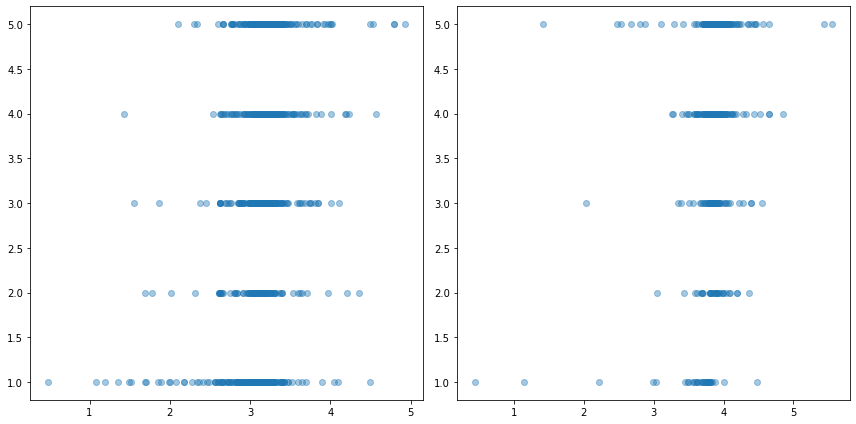

In [54]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].scatter(train_prediction, y_train, alpha=.4)
ax[1].scatter(test_prediction, y_test, alpha=.4)
plt.tight_layout()
plt.show()

### Categorical approach (Naive Bayes)
(3.) is interpreted as a categorical variable $S$ and we aim at estimating $P(S \mid category, adjnoun)$, given that:

$$
P(S \mid category, adjnoun) = \frac{P(S)P(category, adjnoun \mid S)}{P(category, adjnoun)}
$$

In [55]:
S['stars'] = [stars[x] for x in S.doc.values]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(S, S.stars.values, test_size=0.2, random_state=42)

In [57]:
X_train_b = X_train.groupby('stars').head(2000)
X_train_b.groupby('stars').count()

,doc,category,adj,noun
stars,,,,
1,2000,2000,2000,2000
2,2000,2000,2000,2000
3,2000,2000,2000,2000
4,2000,2000,2000,2000
5,2000,2000,2000,2000


In [58]:
X_train = X_train_b.copy()
X_train.head()

,doc,category,adj,noun,stars
20970,645,Ice Cream & Frozen Yogurt,little,bit,4
962,27,Beauty & Spas,first,time,2
52305,1569,Nightlife,spicy,boy,4
69564,2123,Arcades,numerous,time,2
4292,145,Restaurants,classic,egg,4


#### Prior for stars

In [59]:
stars_p = X_train.groupby(['doc']).first().groupby('stars').count()
stars_p['p'] = stars_p.category / stars_p.category.sum()

#### Likelihood of category and adjnoun for stars

In [60]:
cat_an_p_stars = X_train.groupby(['stars', 'category', 'adj', 'noun']).count()
cat_an_p_stars['p'] = cat_an_p_stars.doc.values / cat_an_p_stars.doc.values.sum()

#### Probability of category and adjnoun

In [61]:
cat_an_p = X_train.groupby(['category', 'adj', 'noun']).count()
cat_an_p['p'] = cat_an_p.doc.values / cat_an_p.doc.sum()

#### Predict

In [62]:
from collections import defaultdict

In [63]:
test_data = defaultdict(list)
for i, row in X_test.iterrows():
    test_data[row['doc']].append((
        row['stars'], row['category'], row['adj'], row['noun']
    ))

In [64]:
use_prior = True
y_true, prediction = [], []
running = list(test_data.items())
for doc, doc_data in tqdm(running):
    y_true.append(doc_data[0][0])
    pred = dict([(o, []) for o in range(1, 6)])
    for option in range(1, 6):
        prior = np.log(stars_p.loc[option].p)
        likelihoods = []
        norms = []
        for _, category, adjective, noun in doc_data:
            try:
                likelihood = np.log(cat_an_p_stars.loc[(option, category, adjective, noun)].p)
            except KeyError:
                likelihood = np.log(0.00001)
            try:
                norm = np.log(cat_an_p.loc[(category, adjective, noun)].p)
            except KeyError:
                norm = np.log(0.00001)
            likelihoods.append(likelihood)
            norms.append(norm)
        if use_prior:
            pred[option] = (prior + np.sum(likelihoods)) - np.sum(norms)
        else:
            pred[option] = np.sum(likelihoods) - np.sum(norms)
    prediction.append(pred)
prediction = pd.DataFrame(prediction)

  0%|          | 0/2711 [00:00<?, ?it/s]

In [65]:
y_pred = prediction.idxmax(axis="columns").astype(int)

#### Evaluation

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [67]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.41      0.14      0.20       389
           2       0.21      0.12      0.15       223
           3       0.18      0.09      0.12       324
           4       0.31      0.13      0.18       647
           5       0.45      0.80      0.57      1128

    accuracy                           0.41      2711
   macro avg       0.31      0.26      0.25      2711
weighted avg       0.36      0.41      0.34      2711



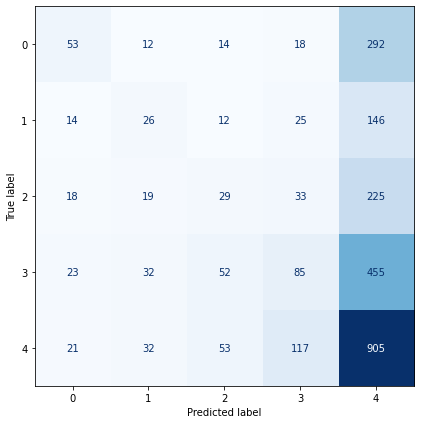

In [68]:
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(ax=ax, cmap='Blues', colorbar=False)
plt.tight_layout()
plt.show()

## Born
[https://eguidotti.github.io/bornrule/](https://eguidotti.github.io/bornrule/)

In [69]:
from bornrule import BornClassifier

### Learn adj-noun relation with number of stars

In [78]:
pseudo_docs, y = [], S.stars.values
categories, adjs, nouns = S.category.values, S.adj.values, S.noun.values
for i, cat in enumerate(categories):
    doc = "{}|{} {}".format(cat, adjs[i], nouns[i])
    pseudo_docs.append(doc)

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [82]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
X = vectorizer.fit_transform(pseudo_docs).toarray() # dense to sparse

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
features = vectorizer.get_feature_names_out()
print(features[:10])

['- \\/' '- alcoholic' '- bar' '- barman' '- beer' '- boyfriend' '- cafe'
 '- car' '- certificate' '- chain']


In [86]:
BC = BornClassifier()

In [87]:
BC.fit(X_train, y_train)

BornClassifier()

In [88]:
y_pred = BC.predict(X_test)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.72      0.84      0.77      2467
           2       0.63      0.82      0.71      1980
           3       0.65      0.79      0.71      2686
           4       0.80      0.73      0.76      4985
           5       0.89      0.75      0.82      7542

    accuracy                           0.77     19660
   macro avg       0.74      0.78      0.76     19660
weighted avg       0.79      0.77      0.77     19660



In [95]:
E = pd.DataFrame(BC.explain(), index=features, columns=[str(x) for x in range(1, 6)])

In [103]:
E.sort_values('5', ascending=False).head(10)

,1,2,3,4,5
general dentistry,0.000000,0.0,0.0,0.000000,0.033619
cosmetic dentists,0.000000,0.0,0.0,0.000000,0.029356
yoga,0.000000,0.0,0.0,0.000000,0.028494
massage,0.011796,0.0,0.0,0.000000,0.027858
much fun,0.000000,0.0,0.0,0.000000,0.023738
outstanding food,0.000000,0.0,0.0,0.000000,0.023697
awesome service,0.000000,0.0,0.0,0.000000,0.023032
orthodontists,0.000000,0.0,0.0,0.000000,0.022122
typical izakaya,0.000000,0.0,0.0,0.000000,0.022066
dentists,0.004274,0.0,0.0,0.010745,0.021960
